# Website categories prediction - Data Science

# Import modules

In [2]:
import logging
from datetime import datetime, timedelta

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
# from selenium import webdriver
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings

%matplotlib inline


---

<center><h1><b>Crawler</b></h1></center>

---

- Simillarweb use protection from http request that generate from code so we needed to change our 'User-Agent' header to look like we our generating the request from a browser
- We used those request to extract the url links for the categories they have and also for the websites list that each category contain
- For the extraction of our relevant itself on each site we used selenium module because SimillarWeb used 'Challenge Validation' Method to implement bot protection, it also contain a 5 second waiting time until the data is present so we added that on each wesite scrapping 
- of Selenium
- We also added a retry mecanism to deal with failed fetching

In [ ]:
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
handle = "my-app"
logger = logging.getLogger("my-app")

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}

data = {"company_name": [], "company_year_founded": [], "company_employees": [], "company_hq": [], "company_annual_revenue": [], "industry": [], "company_total_visits": [], "company_bounce_rate": [],
        "company_pages_per_visit": [], "company_avg_visit_duration_in_seconds": [], "company_3_month_ago": [], "company_2_month_ago": [], "company_1_month_ago": [], "company_demographics_gender_female": [], "company_demographics_gender_male": [], "company_age_distribution_18_24": [], "company_age_distribution_25_34": [], "company_age_distribution_35_44": []}
df = pd.DataFrame(data)
categories_urls = get_categories_urls()

category_index = 0
for category_url in categories_urls:
    category_index += 1
    category_retry = 3
    while category_retry > 0:
        logger.info(f'category_index: {category_index}, category_url: {category_url}')
        try:
            websites_urls = get_websites_urls_from_category(category_url=category_url)
        except:
            category_retry -= 1
            continue
        website_index = 0
        for website_url in websites_urls:
            website_index += 1
            website_retry = 3
            while website_retry > 0:
                try:
                    logger.info(f'website_index: {website_index}, website_url: {website_url}')
                    driver = webdriver.Chrome()
                    driver.get(website_url)
                    time.sleep(5)
                    page_source = driver.page_source
                    driver.quit()
                    soup = BeautifulSoup(page_source, 'html.parser')
                    company_details = soup.find_all('dd', class_='app-company-info__list-item app-company-info__list-item--value')
                    company_name = company_details[0].text.strip()
                    company_year_founded = company_details[1].text.strip()
                    company_employees = company_details[2].text.strip().split()[-1]
                    company_hq = company_details[3].text.strip()
                    company_annual_revenue = company_details[4].text.strip()[:-1].split('$')[-1]
                    industry = company_details[5].text.strip()
                    company_general_stats = soup.find_all('p', class_='engagement-list__item-value')
                    company_total_visits = company_general_stats[0].text.strip()[:-1]
                    company_bounce_rate = company_general_stats[1].text.strip()[:-1]
                    company_pages_per_visit = company_general_stats[2].text.strip()
                    company_avg_visit_duration = company_general_stats[3].text.strip()
                    x = time.strptime(company_avg_visit_duration, '%H:%M:%S')
                    company_avg_visit_duration_in_seconds = timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds()

                    company_total_visits_last_3_months = soup.find_all('tspan', class_='wa-traffic__chart-data-label')
                    company_3_month_ago = company_total_visits_last_3_months[0].text.strip()[:-1]
                    company_2_month_ago = company_total_visits_last_3_months[1].text.strip()[:-1]
                    company_1_month_ago = company_total_visits_last_3_months[2].text.strip()[:-1]
                    company_demographics_gender_stats = soup.find_all('span', class_='wa-demographics__gender-legend-item-value')
                    company_demographics_gender_female = company_demographics_gender_stats[0].text.strip()[:-1]
                    company_demographics_gender_male = company_demographics_gender_stats[1].text.strip()[:-1]
                    company_age_distribution_stats = soup.find_all('tspan', class_='wa-demographics__age-data-label')
                    company_age_distribution_18_24 = company_age_distribution_stats[0].text.strip()[:-1]
                    company_age_distribution_25_34 = company_age_distribution_stats[1].text.strip()[:-1]
                    company_age_distribution_35_44 = company_age_distribution_stats[2].text.strip()[:-1]
                    new_data = {"company_name": company_name, "company_year_founded": company_year_founded, "company_employees": company_employees, "company_hq": company_hq, "company_annual_revenue": company_annual_revenue, "industry": industry, "company_total_visits": company_total_visits, "company_bounce_rate": company_bounce_rate,
                    "company_pages_per_visit": company_pages_per_visit, "company_avg_visit_duration_in_seconds": company_avg_visit_duration_in_seconds, "company_3_month_ago": company_3_month_ago, "company_2_month_ago": company_2_month_ago, "company_1_month_ago": company_1_month_ago, "company_demographics_gender_female": company_demographics_gender_female, "company_demographics_gender_male": company_demographics_gender_male, "company_age_distribution_18_24": company_age_distribution_18_24, "company_age_distribution_25_34": company_age_distribution_25_34, "company_age_distribution_35_44": company_age_distribution_35_44}
                    df.loc[len(df)] = new_data
                    break
                except:
                    website_retry -= 1
                    continue

        df.to_csv(
            r'C:\Users\asus\PycharmProjects\simillarweb_data_science_project\SimilarwebProject.csv')
        break


---

<center><h1><b>Extra Functions</b></h1></center>

---

- We seperated two helper functions for the http requests to fetch both the categories url link and each website they contain



In [ ]:
def get_categories_urls():
    url = 'https://www.similarweb.com/category/'
    response = requests.get(url, headers=headers)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    category_links = soup.find_all('a', class_='tl-list__link')
    urls = ['https://www.similarweb.com' + link['href'] for link in category_links]
    return urls

In [ ]:
def get_websites_urls_from_category(category_url):
    response = requests.get(category_url, headers=headers)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    websites_links = soup.find_all('a', class_='tw-table__row-compare')
    websites_urls = ['https://www.similarweb.com' + link['href'] + '#overview' for link in websites_links]
    return websites_urls

# Data Handling

In [13]:
df=pd.read_csv('SimilarwebProject.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df


,company_name,company_year_founded,company_employees,company_hq,company_annual_revenue,industry,company_total_visits,company_bounce_rate,company_pages_per_visit,company_avg_visit_duration_in_seconds,company_3_month_ago,company_2_month_ago,company_1_month_ago,company_demographics_gender_female,company_demographics_gender_male,company_age_distribution_18_24,company_age_distribution_25_34,company_age_distribution_35_44
0,"YouTube, LLC",2005,10001,"United States, California, San Bruno",1.0,Arts & Entertainment > Streaming & Online TV,33.4,21.22,11.57,1232.0,33.6,32.7,33.4,40.17,59.83,25.68,29.96,18.53
1,"Netflix, Inc.",1997,10001,"United States, California, Los Gatos",1.0,Arts & Entertainment > Streaming & Online TV,1.4,34.51,4.36,340.0,1.5,1.4,1.4,47.03,52.97,30.15,30.98,17.02
2,"Bilibili, Inc.",2009,5000,"China, Yangpu District",1.0,Arts & Entertainment > Animation and Comics,966.5,15.29,11.90,1208.0,970.1,938.9,966.5,26.31,73.69,27.17,38.89,19.41
3,"Fandom, Inc.",2004,500,"United States, California, San Francisco",500.0,Arts & Entertainment > Arts and Entertainment ...,736.2,48.98,4.53,312.0,734.7,748.5,736.2,25.86,74.14,36.30,31.07,15.55
4,IMDb,1990,1000,"United States, Washington, Seattle",500.0,Arts & Entertainment > Streaming & Online TV,497.3,44.58,4.66,198.0,522.8,495.8,497.3,32.85,67.15,25.16,29.70,17.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,- -,- -,-,- -,-,- -,1.0,31.17,11.41,843.0,-,2.3,1.0,27.65,72.35,23.95,25.98,18.56
5842,- -,- -,-,- -,-,- -,1.0,35.33,12.52,1731.0,11,2.8,1.0,16.12,83.88,-,-,-
5843,TriNet,1988,5000,"United States, California, Dublin",1.0,Jobs and Career > Human Resources,1.0,31.09,2.73,122.0,1.3,974.4,1.0,41.60,58.40,20.07,31.42,20.93
5844,youtube to mp3 converter - download mp3 mp4 wa...,- -,-,Germany,-,Jobs and Career > Human Resources,1.0,34.10,2.86,130.0,2.2,699.6,1.0,35.17,64.83,28.88,29.02,17.42


* At this section, we removed duplication based on the company_name field in case the same website was in more than one child category 

* After that, we put a None value on records that contain the char '-' that is the invalid data representaion on Simillarweb site 

* We did that on the following fields: company_name, company_year_founded, company_employees, company_hq, company_annual_revenue, industry

In [14]:
df.drop_duplicates(subset=["company_name"], inplace=True, ignore_index=True)
df.company_name = df.company_name.apply(lambda x: np.nan if x.count('-') > 0 else x)
df.company_year_founded = df.company_year_founded.apply(lambda x: np.nan if x.count('-') > 0 else x)
df.company_employees = df.company_employees.apply(lambda x: np.nan if x.count('-') > 0 else x)
df.company_hq = df.company_hq.apply(lambda x: np.nan if x.count('-') > 0 else x)
df.company_annual_revenue = df.company_annual_revenue.apply(lambda x: np.nan if x.count('-') > 0 else x)
df.industry = df.industry.apply(lambda x: np.nan if x.count('-') > 0 else x)
df

,company_name,company_year_founded,company_employees,company_hq,company_annual_revenue,industry,company_total_visits,company_bounce_rate,company_pages_per_visit,company_avg_visit_duration_in_seconds,company_3_month_ago,company_2_month_ago,company_1_month_ago,company_demographics_gender_female,company_demographics_gender_male,company_age_distribution_18_24,company_age_distribution_25_34,company_age_distribution_35_44
0,"YouTube, LLC",2005,10001,"United States, California, San Bruno",1.0,Arts & Entertainment > Streaming & Online TV,33.4,21.22,11.57,1232.0,33.6,32.7,33.4,40.17,59.83,25.68,29.96,18.53
1,"Netflix, Inc.",1997,10001,"United States, California, Los Gatos",1.0,Arts & Entertainment > Streaming & Online TV,1.4,34.51,4.36,340.0,1.5,1.4,1.4,47.03,52.97,30.15,30.98,17.02
2,"Bilibili, Inc.",2009,5000,"China, Yangpu District",1.0,Arts & Entertainment > Animation and Comics,966.5,15.29,11.90,1208.0,970.1,938.9,966.5,26.31,73.69,27.17,38.89,19.41
3,"Fandom, Inc.",2004,500,"United States, California, San Francisco",500.0,NaN,736.2,48.98,4.53,312.0,734.7,748.5,736.2,25.86,74.14,36.30,31.07,15.55
4,IMDb,1990,1000,"United States, Washington, Seattle",500.0,Arts & Entertainment > Streaming & Online TV,497.3,44.58,4.66,198.0,522.8,495.8,497.3,32.85,67.15,25.16,29.70,17.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,"oVice, Inc.",2020,200,NaN,10.0,Jobs and Career > Human Resources,1.1,33.24,3.99,435.0,1.1,929.6,1.1,29.09,70.91,14.40,41.81,28.25
4071,G&A Partners,1995,500,"United States, Texas, Houston",1.0,Jobs and Career > Human Resources,1.1,51.34,3.02,430.0,1.1,1.0,1.1,42.12,57.88,16.59,24.30,20.18
4072,"Globalization Partners, LLC.",2012,1000,"United States, Massachusetts, Boston",200.0,Jobs and Career > Human Resources,1.1,58.26,5.98,79.0,1.2,1.1,1.1,42.67,57.33,20.43,33.96,20.96
4073,TriNet,1988,5000,"United States, California, Dublin",1.0,Jobs and Career > Human Resources,1.0,31.09,2.73,122.0,1.3,974.4,1.0,41.60,58.40,20.07,31.42,20.93


* We wrote to helper function to check if a value is a float type or int type to clean invalid data of the numeric rows we extract

In [15]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [16]:
def isint(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

* At this section, we used the helper functions from above to put the None value also on the numeric fields where to value is invalid

In [17]:
df.company_bounce_rate = df.company_bounce_rate.apply(lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_3_month_ago = df.company_3_month_ago.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_2_month_ago = df.company_2_month_ago.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_demographics_gender_female = df.company_demographics_gender_female.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_demographics_gender_male = df.company_demographics_gender_male.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_age_distribution_18_24 = df.company_age_distribution_18_24.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_age_distribution_25_34 = df.company_age_distribution_25_34.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df.company_age_distribution_35_44 = df.company_age_distribution_35_44.apply(
    lambda x: np.nan if not isfloat(x) and not isint(x) else x)
df

,company_name,company_year_founded,company_employees,company_hq,company_annual_revenue,industry,company_total_visits,company_bounce_rate,company_pages_per_visit,company_avg_visit_duration_in_seconds,company_3_month_ago,company_2_month_ago,company_1_month_ago,company_demographics_gender_female,company_demographics_gender_male,company_age_distribution_18_24,company_age_distribution_25_34,company_age_distribution_35_44
0,"YouTube, LLC",2005,10001,"United States, California, San Bruno",1.0,Arts & Entertainment > Streaming & Online TV,33.4,21.22,11.57,1232.0,33.6,32.7,33.4,40.17,59.83,25.68,29.96,18.53
1,"Netflix, Inc.",1997,10001,"United States, California, Los Gatos",1.0,Arts & Entertainment > Streaming & Online TV,1.4,34.51,4.36,340.0,1.5,1.4,1.4,47.03,52.97,30.15,30.98,17.02
2,"Bilibili, Inc.",2009,5000,"China, Yangpu District",1.0,Arts & Entertainment > Animation and Comics,966.5,15.29,11.90,1208.0,970.1,938.9,966.5,26.31,73.69,27.17,38.89,19.41
3,"Fandom, Inc.",2004,500,"United States, California, San Francisco",500.0,NaN,736.2,48.98,4.53,312.0,734.7,748.5,736.2,25.86,74.14,36.30,31.07,15.55
4,IMDb,1990,1000,"United States, Washington, Seattle",500.0,Arts & Entertainment > Streaming & Online TV,497.3,44.58,4.66,198.0,522.8,495.8,497.3,32.85,67.15,25.16,29.70,17.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,"oVice, Inc.",2020,200,NaN,10.0,Jobs and Career > Human Resources,1.1,33.24,3.99,435.0,1.1,929.6,1.1,29.09,70.91,14.40,41.81,28.25
4071,G&A Partners,1995,500,"United States, Texas, Houston",1.0,Jobs and Career > Human Resources,1.1,51.34,3.02,430.0,1.1,1.0,1.1,42.12,57.88,16.59,24.30,20.18
4072,"Globalization Partners, LLC.",2012,1000,"United States, Massachusetts, Boston",200.0,Jobs and Career > Human Resources,1.1,58.26,5.98,79.0,1.2,1.1,1.1,42.67,57.33,20.43,33.96,20.96
4073,TriNet,1988,5000,"United States, California, Dublin",1.0,Jobs and Career > Human Resources,1.0,31.09,2.73,122.0,1.3,974.4,1.0,41.60,58.40,20.07,31.42,20.93


* In this section, we clear the following fields of company_name, company_hq and industry from chars that will not work with the machine learning algorithms 

* We extract the parent category from each full catogery that also contain a child category and saved all the records with only the parent category

* Then we droped all the records with the None values that we put on invalid data before

* We also checked for categories that contain only 1 record (categories that contain bad data on the Simillarweb site) and removed them because they will mess up the machine learning algorithms

* after all the cleaning process we saved the clean DataFrame into new csv file

In [19]:
df['company_name'] = df['company_name'].str.replace(r'[^a-zA-Z0-9]', '')
df['company_hq'] = df['company_hq'].str.replace(r'[^a-zA-Z0-9]', '')
splited_values = df['industry'].str.split('>', n=1)
df['industry'] = splited_values.str[0].str.replace(r'[^a-zA-Z0-9]', '')
df.dropna(inplace=True)
industry_counts = df['industry'].value_counts()
single_industries = industry_counts[industry_counts == 1].index
df = df[~df['industry'].isin(single_industries)]
df.to_csv('SimilarwebProject_cleaned.csv')
df

C:\Users\asus\AppData\Local\Temp\ipykernel_17304\2749341451.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['company_name'] = df['company_name'].str.replace(r'[^a-zA-Z0-9]', '')
C:\Users\asus\AppData\Local\Temp\ipykernel_17304\2749341451.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['company_hq'] = df['company_hq'].str.replace(r'[^a-zA-Z0-9]', '')
C:\Users\asus\AppData\Local\Temp\ipykernel_17304\2749341451.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['industry'] = splited_values.str[0].str.replace(r'[^a-zA-Z0-9]', '')


,company_name,company_year_founded,company_employees,company_hq,company_annual_revenue,industry,company_total_visits,company_bounce_rate,company_pages_per_visit,company_avg_visit_duration_in_seconds,company_3_month_ago,company_2_month_ago,company_1_month_ago,company_demographics_gender_female,company_demographics_gender_male,company_age_distribution_18_24,company_age_distribution_25_34,company_age_distribution_35_44
0,YouTubeLLC,2005,10001,UnitedStatesCaliforniaSanBruno,1.0,ArtsEntertainment,33.4,21.22,11.57,1232.0,33.6,32.7,33.4,40.17,59.83,25.68,29.96,18.53
1,NetflixInc,1997,10001,UnitedStatesCaliforniaLosGatos,1.0,ArtsEntertainment,1.4,34.51,4.36,340.0,1.5,1.4,1.4,47.03,52.97,30.15,30.98,17.02
2,BilibiliInc,2009,5000,ChinaYangpuDistrict,1.0,ArtsEntertainment,966.5,15.29,11.90,1208.0,970.1,938.9,966.5,26.31,73.69,27.17,38.89,19.41
4,IMDb,1990,1000,UnitedStatesWashingtonSeattle,500.0,ArtsEntertainment,497.3,44.58,4.66,198.0,522.8,495.8,497.3,32.85,67.15,25.16,29.70,17.36
5,SpotifyAB,2006,10000,SwedenStockholm,1.0,ArtsEntertainment,491.8,36.13,5.92,491.0,484.2,473.7,491.8,43.04,56.96,30.86,31.30,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,WageWorks,2000,5000,UnitedStatesCaliforniaSanMateo,500.0,JobsandCareer,1.3,24.85,10.97,440.0,1.8,1.4,1.3,44.45,55.55,13.83,28.38,21.30
4069,PeopleAdminInc,2000,500,UnitedStatesTexasAustin,50.0,JobsandCareer,1.2,37.77,6.27,434.0,1.1,964.1,1.2,55.41,44.59,25.59,24.77,17.65
4071,GAPartners,1995,500,UnitedStatesTexasHouston,1.0,JobsandCareer,1.1,51.34,3.02,430.0,1.1,1.0,1.1,42.12,57.88,16.59,24.30,20.18
4072,GlobalizationPartnersLLC,2012,1000,UnitedStatesMassachusettsBoston,200.0,JobsandCareer,1.1,58.26,5.98,79.0,1.2,1.1,1.1,42.67,57.33,20.43,33.96,20.96


# EDA & Visualiztion

# Count of industries

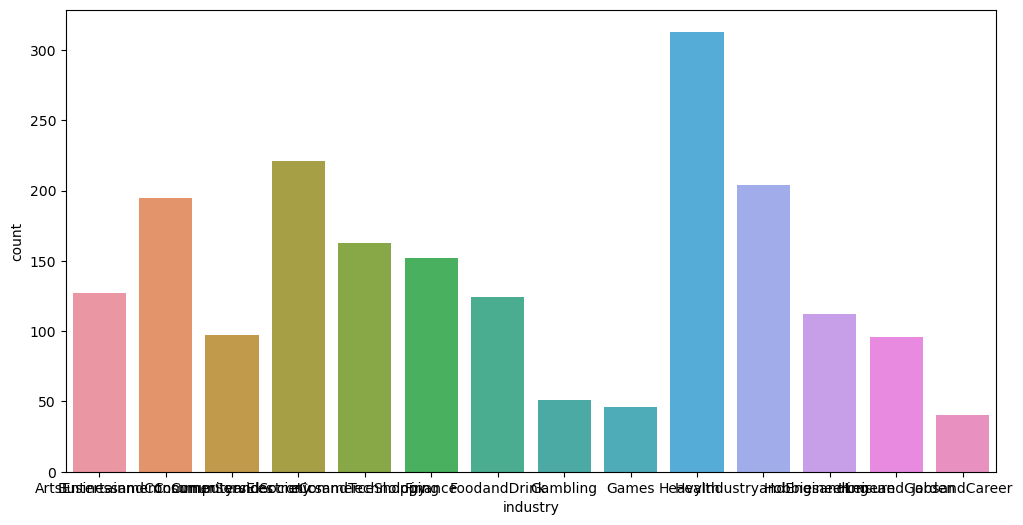

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x='industry', data=df)
plt.show()

# Heatmap

* The colors show how strong is the connection between 2 parameters(cols), while as much as it closer to 1, as much as the connection stronger. It is a good way to sum up the corr numbers.

C:\Users\asus\AppData\Local\Temp\ipykernel_17304\137295111.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

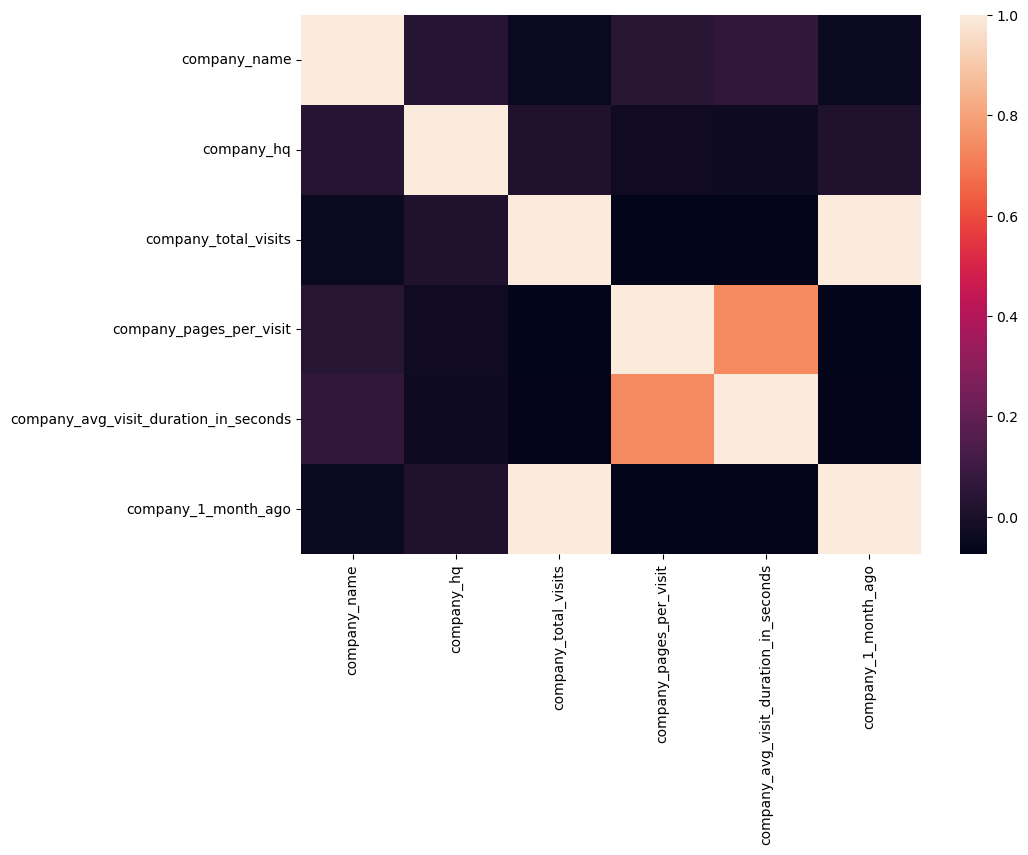

In [31]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr())

- Coralation between high number of employees and the total visits of the company website


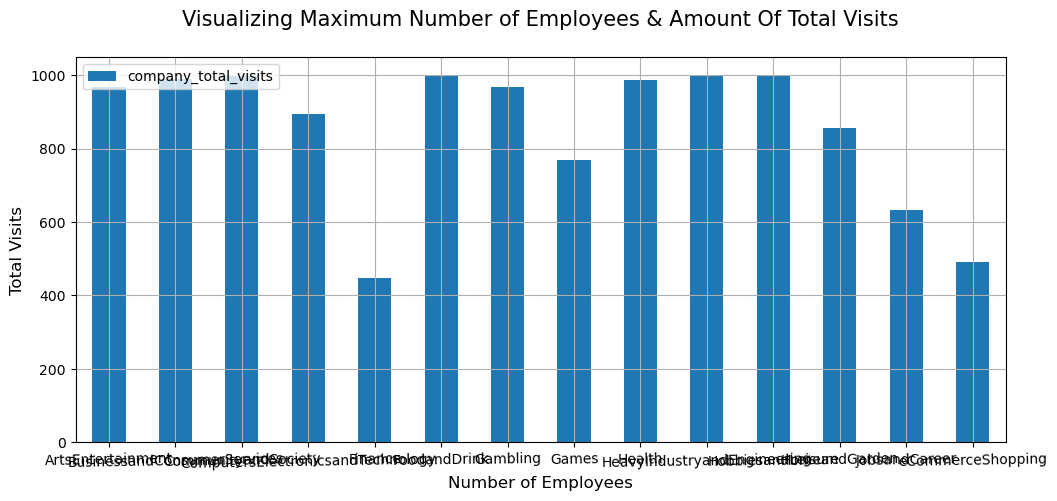

In [34]:
df.groupby('industry').agg({"company_employees":'max',"company_total_visits":'max'}).plot(kind = 'bar', rot=1, figsize=(12,5))

plt.title("Visualizing Maximum Number of Employees & Amount Of Total Visits\n", size=15)
plt.grid()
plt.legend(loc='upper left')
plt.xlabel("Number of Employees", size=12)
plt.ylabel("Total Visits", size=12)
plt.show()

- Coralation between number of total visits of the company website and the avarage duration time on it, we can see that high number of total visits on the site not directly cause a high number of avarage visits duration

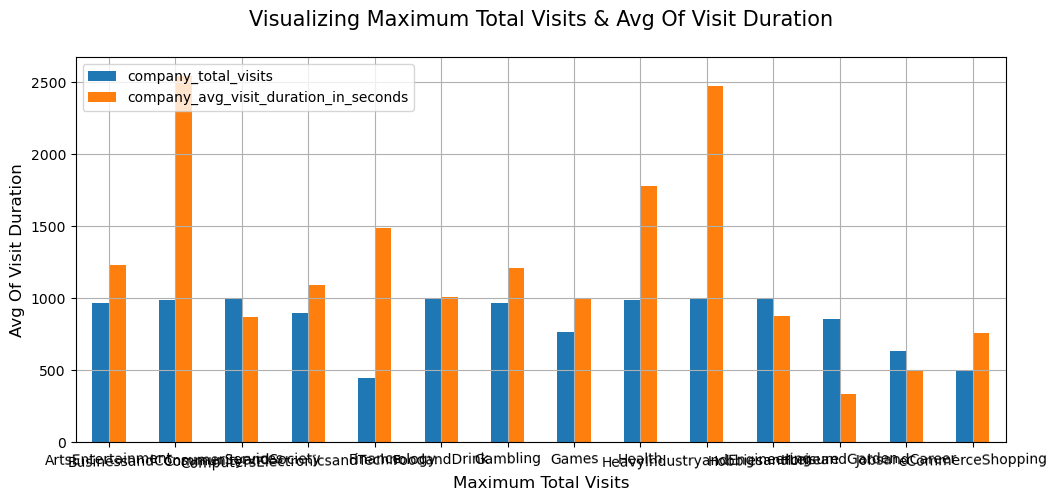

In [38]:
df.groupby('industry').agg({"company_total_visits":'max',"company_avg_visit_duration_in_seconds":'max'}).plot(kind = 'bar', rot=1, figsize=(12,5))

plt.title("Visualizing Maximum Total Visits & Avg Of Visit Duration\n", size=15)
plt.grid()
plt.legend(loc='upper left')
plt.xlabel("Maximum Total Visits", size=12)
plt.ylabel("Avg Of Visit Duration", size=12)
plt.show()

# Machine Learning

* Since we try to predict the categorical column called 'industry' we splitted the data and extracted the industry column to 'y' variable and the rest of the columns to X variable

* After splitting the data to X and y, we splitted it again to XTrain, XTest, yTrain, yTest using train_test_split function of sklearn. we used the random_state=42(standard number) for randomize the instances and test_size=0.2 in order to get 80% of the data to train and 20% to the test(standard).

* We used the following algorithms: Random Forest, Logistic Regression, Naive Bayes

* For each algorithm we show the score and its confusion matrix



The model Random Forest have score of 0.46272493573264784.
 Confusion Matrix:






The model Naive Bayes have score of 0.15681233933161953.
 Confusion Matrix:






The model Logistic Regression have score of 0.2236503856041131.
 Confusion Matrix:






C:\Users\asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


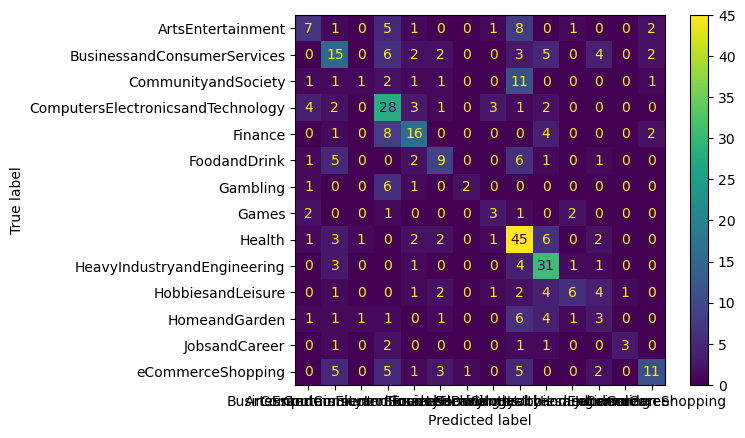

<Figure size 1200x600 with 0 Axes>

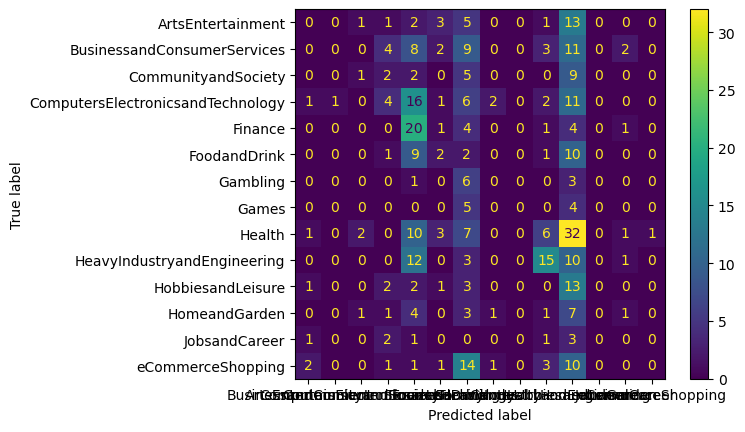

<Figure size 1200x600 with 0 Axes>

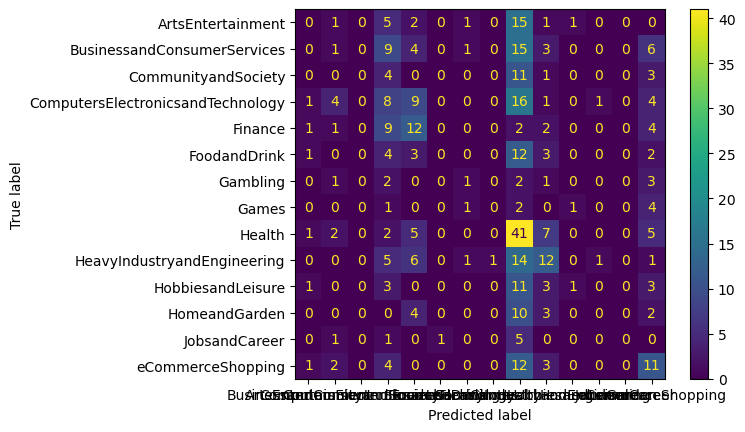

<Figure size 1200x600 with 0 Axes>

In [40]:
categorical_columns = ['company_name', 'company_hq']
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
X = df.drop(columns=["industry"], axis=1)

y = label_encoder.fit_transform(df['industry'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rd = RandomForestClassifier()
lg = LogisticRegression()
naive = MultinomialNB()
best_recall_val = 0
result = []
for clf, model in zip([rd, naive, lg], ["Random Forest", "Naive Bayes", "Logistic Regression"]):
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    clf_score_test = accuracy_score(y_true=y_test, y_pred=y_predicted)
    result.append({"Model": model, "y_test_score": clf_score_test})
    print(f"\n\nThe model {model} have score of {clf_score_test}.\n Confusion Matrix:\n")
    cm = confusion_matrix(y_true=y_test, y_pred=y_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(include_values=True)
    plt.figure(figsize=(12, 6))
    print("\n\n")

* Here we show a plot of each algorithm and its score

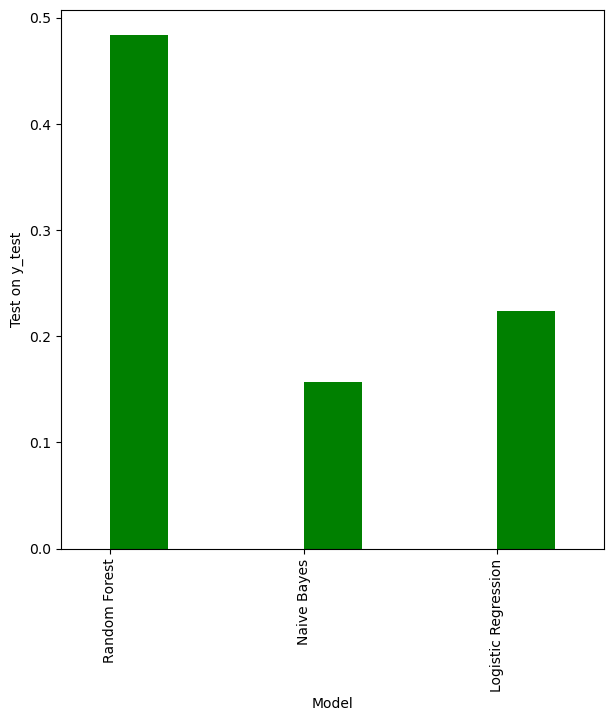

In [29]:
result_df = pd.DataFrame(result)
result_df = result_df.set_index('Model')
fig = plt.figure(figsize=(7, 7))  # Create matplotlib figure
ax = fig.add_subplot(111)  # Create matplotlib axes
width = .3
result_df.y_test_score.plot(kind='bar', color='green', ax=ax, width=width, position=0)
ax.set_ylabel('Test on y_test')
print("\n")
plt.show()

* We took the algorithm with the best score which was Random Forest with a score of: 0.46272493573264784 and tried to run it with the best features we find with GridSearch

{'n_estimators': 200}


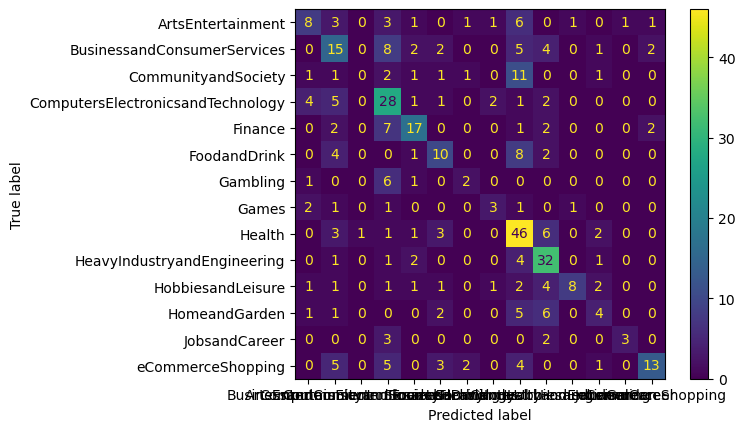


 0.48586118251928023


In [26]:
parameters = {'n_estimators': range(50, 550, 50)}
rd = RandomForestClassifier()
gs = GridSearchCV(rd, parameters)
gs.fit(X_train, y_train)
print(gs.best_params_)

rd = RandomForestClassifier(**gs.best_params_)
rd.fit(X_train, y_train)
y_predicted = rd.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_predicted)
cm = confusion_matrix(y_true=y_test, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(include_values=True)
plt.show()
print('\n', score)